In [13]:
import pandas as pd

trades = pd.read_csv('/content/historical_data.csv')  # remove parse_dates for now
print(trades.columns)
trades.head()
sent = pd.read_csv('/content/fear_greed_index.csv')
print(sent.columns)
sent.head()

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


/tmp/ipython-input-22473516.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv('/content/historical_data.csv')  # remove parse_dates for now


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [14]:

trades = pd.read_csv('/content/historical_data.csv', parse_dates=['Timestamp'])
trades.rename(columns={'Timestamp': 'time'}, inplace=True)

sent = pd.read_csv('/content/fear_greed_index.csv', parse_dates=['date'])
sent.rename(columns={'date>': 'date'}, inplace=True)

trades.info()
sent.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153900 entries, 0 to 153899
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           153900 non-null  object 
 1   Coin              153900 non-null  object 
 2   Execution Price   153900 non-null  float64
 3   Size Tokens       153900 non-null  float64
 4   Size USD          153900 non-null  float64
 5   Side              153900 non-null  object 
 6   Timestamp IST     153900 non-null  object 
 7   Start Position    153900 non-null  float64
 8   Direction         153900 non-null  object 
 9   Closed PnL        153900 non-null  float64
 10  Transaction Hash  153899 non-null  object 
 11  Order ID          153899 non-null  float64
 12  Crossed           153899 non-null  object 
 13  Fee               153899 non-null  float64
 14  Trade ID          153899 non-null  float64
 15  time              153899 non-null  object 
dtypes: float64(8), objec

/tmp/ipython-input-303705708.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv('/content/historical_data.csv', parse_dates=['Timestamp'])
/tmp/ipython-input-303705708.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trades = pd.read_csv('/content/historical_data.csv', parse_dates=['Timestamp'])


In [15]:
import matplotlib.pyplot as plt

# Calculate returns
plt.savefig('/content/returns_by_sentiment.png', dpi=150, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [16]:
def normalize_cols(df):
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    return df

trades = normalize_cols(trades)
sent = normalize_cols(sent)

# Drop duplicates
trades = trades.drop_duplicates()
sent = sent.drop_duplicates()

print(trades.info())
print(sent.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153900 entries, 0 to 153899
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   account           153900 non-null  object 
 1   coin              153900 non-null  object 
 2   execution_price   153900 non-null  float64
 3   size_tokens       153900 non-null  float64
 4   size_usd          153900 non-null  float64
 5   side              153900 non-null  object 
 6   timestamp_ist     153900 non-null  object 
 7   start_position    153900 non-null  float64
 8   direction         153900 non-null  object 
 9   closed_pnl        153900 non-null  float64
 10  transaction_hash  153899 non-null  object 
 11  order_id          153899 non-null  float64
 12  crossed           153899 non-null  object 
 13  fee               153899 non-null  float64
 14  trade_id          153899 non-null  float64
 15  time              153899 non-null  object 
dtypes: float64(8), objec

In [20]:
print(trades['time'].head())
print(trades['time'].dtype)

0   1970-01-20 10:40:00
1   1970-01-20 10:40:00
2   1970-01-20 10:40:00
3   1970-01-20 16:13:20
4   1970-01-20 16:13:20
Name: time, dtype: datetime64[ns]
datetime64[ns]


In [42]:
# Map sentiment to numeric
sent['sentiment_num'] = sent['classification'].map({
    'Extreme Fear': -1,
    'Fear': 0,
    'Greed': 1,
    'Extreme Greed': 2
})

# Parse datetime carefully
try:
    trades['time'] = pd.to_datetime(trades['time'], unit='us')
except (ValueError, OverflowError):
    # Fallback: parse as string (if not epoch)
    trades['time'] = pd.to_datetime(trades['time'], dayfirst=True, errors='coerce')

sent['date'] = pd.to_datetime(sent['date'], dayfirst=True, errors='coerce')

# Sort before merge
trades = trades.sort_values('time')
sent = sent.sort_values('date')

# Drop invalid times
trades = trades.dropna(subset=['time'])

# Merge sentiment data using nearest backward date
trades = pd.merge_asof(
    trades,
    sent[['date', 'sentiment_num']],
    left_on='time',
    right_on='date',
    direction='backward'
)

# ✅ Sanity check after merge
print(trades[['time', 'sentiment_num']].head())
print("\nSentiment counts after merge:")
print(trades['sentiment_num'].value_counts(dropna=False))


                 time  sentiment_num
0 2023-05-01 01:06:00            1.0
1 2023-05-01 01:06:00            1.0
2 2023-05-01 01:06:00            1.0
3 2023-12-05 03:11:00            2.0
4 2023-12-05 03:11:00            2.0

Sentiment counts after merge:
sentiment_num
 0.0    43608
 1.0    39053
 2.0    30920
 NaN    26856
-1.0    13462
Name: count, dtype: int64


In [21]:
import numpy as np

# Calculate notional
trades['return_pct'] = trades['closed_pnl'] / trades['size_usd'].replace(0, np.nan)
trades['profitable'] = (trades['closed_pnl'] > 0).astype(int)


trades['hour'] = pd.to_datetime(trades['timestamp_ist'], format='%d-%m-%Y %H:%M', dayfirst=True).dt.hour
trades['weekday'] = pd.to_datetime(trades['timestamp_ist'], format='%d-%m-%Y %H:%M', dayfirst=True).dt.weekday

if 'leverage' in trades.columns:
    trades['leverage_bucket'] = pd.qcut(trades['leverage'], q=3, labels=['Low','Medium','High'])

In [23]:
from scipy.stats import ttest_ind

greed = trades[trades['sentiment_num'] == 1]['return_pct'].dropna()
fear  = trades[trades['sentiment_num'] == 0]['return_pct'].dropna()

t_stat, p_val = ttest_ind(greed, fear, equal_var=False)
print(f"T-test: t={t_stat:.3f}, p={p_val:.4f}")


T-test: t=nan, p=nan


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

feature_cols = ['sentiment_num','hour','weekday']
X = trades[feature_cols].fillna(0)
y = trades['profitable']

tscv = TimeSeriesSplit(n_splits=5)
scores = []
for train_idx, test_idx in tscv.split(X):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = model.predict_proba(X.iloc[test_idx])[:, 1]
    auc = roc_auc_score(y.iloc[test_idx], preds)
    scores.append(auc)

print("ROC-AUC per fold:", scores)
print("Mean ROC-AUC:", np.mean(scores))


ROC-AUC per fold: [np.float64(0.47569228753414466), np.float64(0.4959605715247455), np.float64(0.46621928049846445), np.float64(0.40708431943868945), np.float64(0.5267692968929482)]
Mean ROC-AUC: 0.47434515117779846


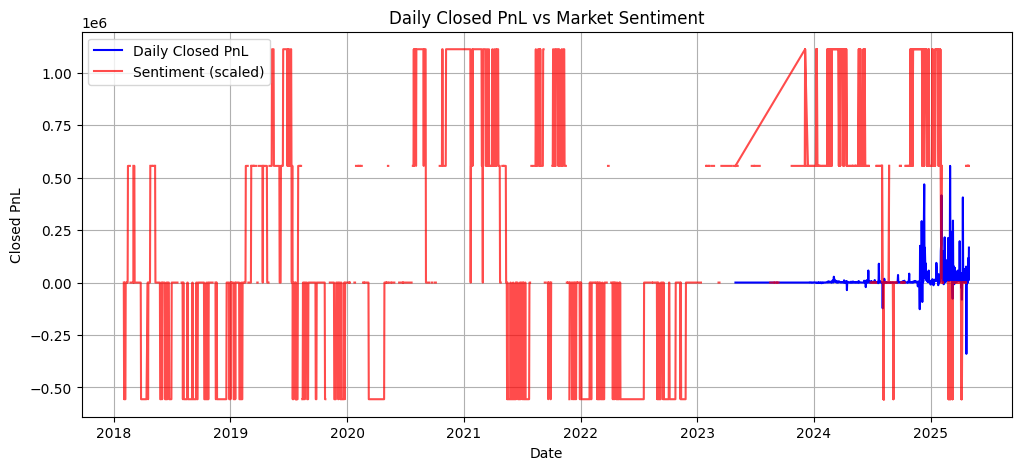

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Fix: parse with dayfirst=True
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], dayfirst=True, errors='coerce')
sent['date'] = pd.to_datetime(sent['date'], dayfirst=True, errors='coerce')

# 1️⃣ Compute daily PnL
daily_pnl = trades.groupby(trades['timestamp_ist'].dt.date)['closed_pnl'].sum()

# 2️⃣ Prepare daily sentiment
daily_sent = sent.set_index('date')['sentiment_num']

# 3️⃣ Join data
daily_df = pd.concat([daily_pnl, daily_sent], axis=1)

# 4️⃣ Plot
plt.figure(figsize=(12,5))
plt.plot(daily_df.index, daily_df['closed_pnl'], label='Daily Closed PnL', color='blue')

# Scale sentiment to match PnL visually
if not daily_df['closed_pnl'].empty:
    scaled_sentiment = daily_df['sentiment_num'] * daily_df['closed_pnl'].abs().max()
    plt.plot(daily_df.index, scaled_sentiment, label='Sentiment (scaled)', color='red', alpha=0.7)

plt.title("Daily Closed PnL vs Market Sentiment")
plt.xlabel("Date")
plt.ylabel("Closed PnL")
plt.legend()
plt.grid(True)

# 5️⃣ Save figure
plt.savefig('/content/daily_pnl_vs_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
trades.to_csv('/content/trades_with_sentiment.csv', index=False)
print("Processed trades saved as trades_with_sentiment.csv")


/tmp/ipython-input-4083126960.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(data,


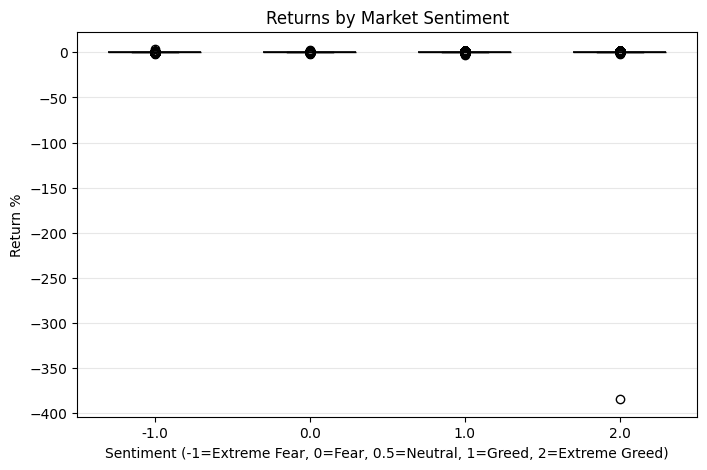

Saved: /content/outputs/returns_by_sentiment.png


In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ensure outputs folder exists
os.makedirs('/content/outputs', exist_ok=True)

# 1) create return_pct if missing
if 'return_pct' not in trades.columns:
    trades['return_pct'] = trades['closed_pnl'] / trades['size_usd'].replace(0, np.nan)

# 2) filter out rows where sentiment_num is NaN
trades_filtered = trades.dropna(subset=['sentiment_num'])

# 3) build data arrays per sentiment category (sorted)
cats = sorted(trades_filtered['sentiment_num'].unique())
if len(cats) == 0:
    raise ValueError("No sentiment values found in trades['sentiment_num'] after filtering.")
data = [trades_filtered.loc[trades_filtered['sentiment_num'] == c, 'return_pct'].dropna() for c in cats]

# 4) choose colors (extend if more than 2 categories)
base_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
colors = [base_colors[i % len(base_colors)] for i in range(len(cats))]

# 5) plot with matplotlib boxplot and color the boxes
fig, ax = plt.subplots(figsize=(8,5))
bplot = ax.boxplot(data,
                   labels=[str(c) for c in cats],
                   patch_artist=True,
                   widths=0.6,
                   showfliers=True)

# color boxes & style medians
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set(color='black', linewidth=1.2)

ax.set_title("Returns by Market Sentiment")
ax.set_xlabel("Sentiment (-1=Extreme Fear, 0=Fear, 0.5=Neutral, 1=Greed, 2=Extreme Greed)")
ax.set_ylabel("Return %")
ax.grid(axis='y', alpha=0.3)

# 6) save to outputs
out_path = '/content/outputs/returns_by_sentiment.png'
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()

print("Saved:", out_path)